# Animal Shelter Outcomes



## Business Understanding

### What problem are we trying to solve?
Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.  We need to understand which animals are at the greatest risk of euthanization in order to help them.

### What are the relevant metrics?  How much do we plan to improve them?
We will use the multiclass logarithmic loss of our predictions on the test data to evaluate the successfullness.

### What will we deliver?
We will deliver a model that can predict the probability of each of the four possible outcomes for every animal in the data set, and an overall score for that model.  If possible, we will identify some of the more prominent features in the model in order to give visibility into risk factors for euthanization.


## Data Understanding

In [185]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import re
import math
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [186]:
# Read in data
raw_data = pd.read_csv('train.csv', index_col=False)
test_data = pd.read_csv('test.csv', index_col=False)

In [187]:
raw_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [188]:
test_data.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### What are the raw data sources and what does each unit of data represent?

- The raw data is sourced from Austin Animal Center, and each unit is an animal record that had stayed in the that shelter in the past.

**What are the fields?**

- AnimalID – A unique identifier of each shelter animal
- Name – An animal’s name
- OutcomeType – Different kind of outcomes for shelter animals. Possibly options are adopted, return to owner, died, euthanized, and transfer
- DateTime – The time when one of the OutcomeType occurred for an animal
- OutcomeSubtype – Further breakdown of major outcome type.  This is not present in test data
- AnimalType – Dog or cat
- SexuponOutcome – Male or Female. Whether an animal is intact, neutered or spayed
- AgeuponOutcome – An animal’s age when one of the outcomes happened
- Breed – Different breeds of dogs and cats
- Color – Colors of the shelter animals


### Exploratory Data Analysis

   * *Distribution of Outcome*

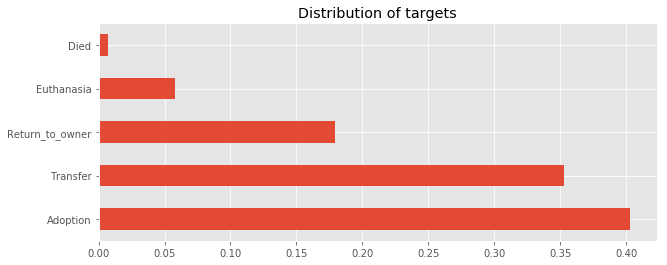

In [189]:
raw_data.OutcomeType.value_counts(normalize=True).plot(kind='barh', figsize=(10, 4), title='Distribution of targets')

It is great that most sheltered animals are either adopted or transferred, and only 6% of them are euthanasiaed. For our project purposes, it can be challenging to predict targets such as 'Died' or 'Euthanasia' because of the low percentage of occurances.

   * *Distribution of each feature*

#### AnimalType

In [190]:
print raw_data.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64


There are more dogs than cats in the training data, but both types have sufficient amount of data for us to train a model. 

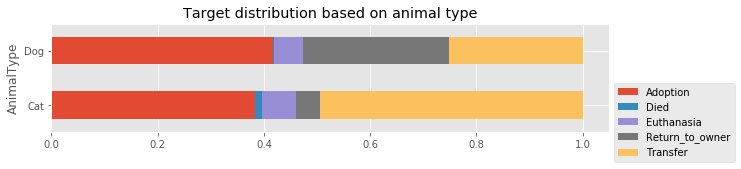

In [191]:
ax = raw_data.groupby(by='AnimalType')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,2), title='Target distribution based on animal type')
ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

- Cats are disproportionally in the transfer category. Second, a lot more dogs were able to return to their owners than cats. These characteristics can be used to predict the outcomes. 

#### SexuponOutcome

In [192]:
print np.round(raw_data.SexuponOutcome.value_counts(normalize=True),2)

Neutered Male    0.37
Spayed Female    0.33
Intact Male      0.13
Intact Female    0.13
Unknown          0.04
Name: SexuponOutcome, dtype: float64


- There are about the same numbers of male vs female. Interestingly, Majority of animals are either neutered or spayed, which can increase the adoptability since on average neutered or spayed animals have better health on average.

- 4% of animals have unknown gender, which we need to handle it later when we do feature engineering. 

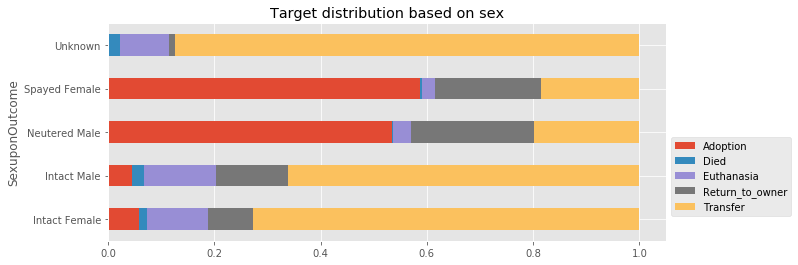

In [193]:
ax = raw_data.groupby(by='SexuponOutcome')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4), title='Target distribution based on sex')
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- Neutered or spayed pets are much more likely to be adopted. One reason could be the cost associated with undergoing such surgeries, which discourage adopters to choose an intact pet. On the other hand, whether the sheltered animals are male or female does not seem to make a difference in terms of outcome. This information can be useful when we do feature engineering. Lastly, there is an "unknown" type that seems to be closer to intact female. 

#### AgeuponOutcome

- The AgeuponOutcome variable is stored as a string containing an amount and a unit.  
- We will convert these into days so that we have a continous variable

In [194]:
raw_data['AgeuponOutcome'].value_counts()[:10]

1 year      3969
2 years     3742
2 months    3397
3 years     1823
1 month     1281
3 months    1277
4 years     1071
5 years      992
4 months     888
6 years      670
Name: AgeuponOutcome, dtype: int64

In [195]:
data = raw_data.copy()
#Separate age into a number and a string
data['Age_num'] = data['AgeuponOutcome'].str[:2].str.strip().astype(int, raise_on_error=False)
data['Age_str'] = data['AgeuponOutcome'].str[2:].str.strip()

#Bin units of time
factor = {'years':365, 'year':365, 'month':30, 'months':30, 'week': 7, 'weeks':7, 'day':1, 'days':1}
data['Age_factor'] = data['Age_str'].map(lambda x: factor[x] if x in factor.keys() else 6000)
#NOTE: 8000 is used for illustrative purposes, so that unknowns are not plotted as very young animals

#Multiply the number in the age by the factor for comparable numerical column.  Drop and derivitive columns
data['Age_num'] = data['Age_num'].astype(float)
data['Age_days'] = data['Age_num'].mul(data['Age_factor'], axis='index').fillna(0)
data.drop(['Age_num', 'Age_str', 'Age_factor'], 1, inplace = True)

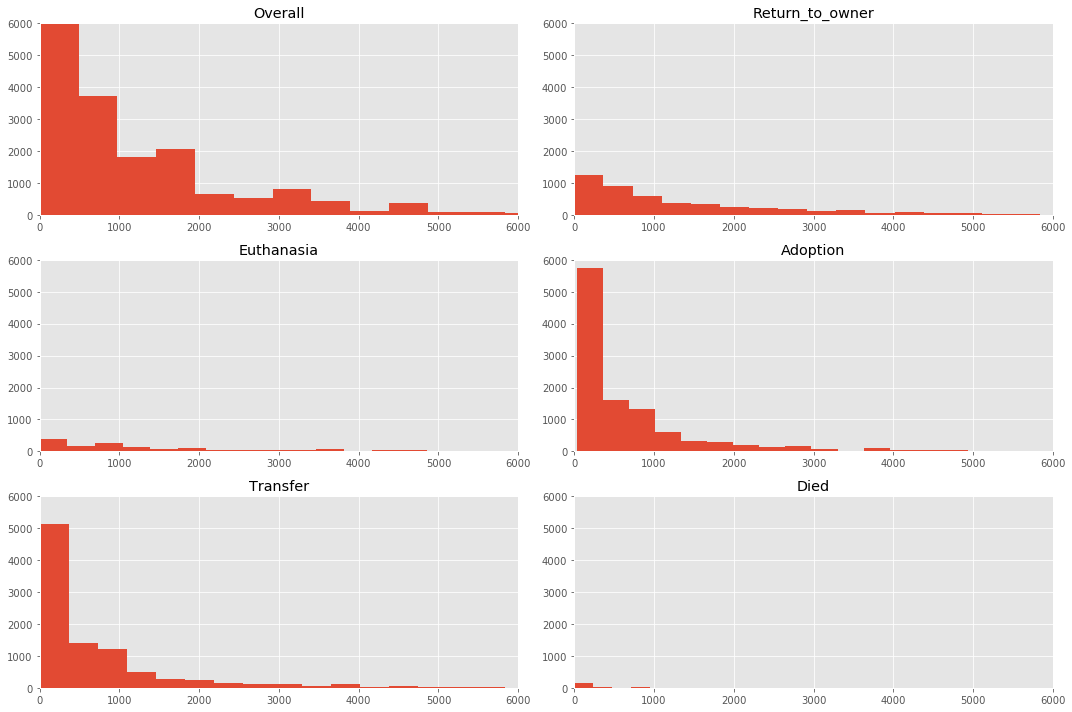

In [196]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
f.set_size_inches(15, 10)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for val, outcome in enumerate(np.append('Overall', data['OutcomeType'].unique())):
    if outcome == 'Overall':
        axes[val].hist(data['Age_days'], bins=15)
    else:
        axes[val].hist(data[data['OutcomeType'] == outcome]['Age_days'], bins=20)
    axes[val].set_xlim([0,6000])
    axes[val].set_ylim([0, 6000])
    axes[val].set_title(outcome)
    
plt.tight_layout()

- Majority of animals are younger than 1 year. The reason can be because most pet owners cannot handle so many babies at the same time so they have to abandom some of them. We can see that the number gradually decreases as the age increases.

- The younger the animals, the more likely they will be adopted. However, this is not true in the infant case where there are no adoption case. It is probably because animals that are younger than 2 months are not made available to be adopted, as it requires extra care. 

- On the other hand, the older the animals, the more likely they will either be euthanized or returned to their owners. Both scenarios make intuitive sense. Older animals are probably owned and hence more likely to be returned. Also, older animals tend to have worse health and people typically prefer to adopt younger animals, so they are more likely to be euthanized. 

#### Datetime

In [197]:
temp = pd.to_datetime(data['DateTime']).dt.hour
bins = [3, 7, 10, 14, 17, 20, 24]
names = ['midnight','morning', 'lunch', 'afternoon','night', 'late night']
data['OutcomeHour'] = pd.cut(temp, bins, labels=names)

temp = pd.to_datetime(test_data['DateTime']).dt.hour
test_data['OutcomeHour'] = pd.cut(temp, bins, labels=names)

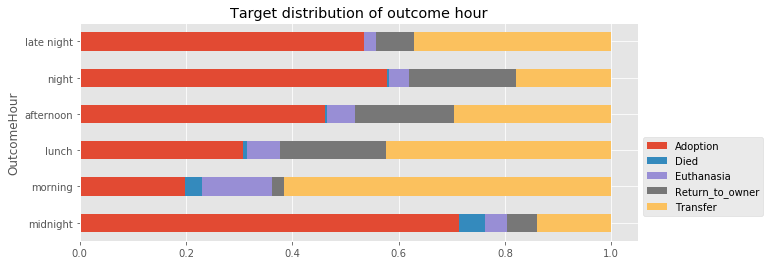

In [198]:
ax = data.groupby(by='OutcomeHour')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4), title='Target distribution of outcome hour')
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- We notice that a lot of adoption occurred during night time, which is surprising since we expect that to happen during afternoon. We also see more transferring and euthanasia happen in the morning, which can make sense since morning is less busy with adoption.

#### Breed

- There are way too many types of breed in the data. We will use feature hashing techniques and category reduction to handle it. Additionally, one thing we can do is to categorize breeds that are popular in America versus breeds that are typically not 'loved' by general public.

In [199]:
len(data.Breed.unique())

1380

In [200]:
popular_names = ['german shepherd', 'labrador', 'golden retriever', 'beagle', 'bulldog', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund']
unpopular_names = ['pit bull', 'chihuahua']
cv = CountVectorizer(vocabulary=popular_names)
test = cv.fit_transform(data['Breed'])
test = np.sum(test.toarray(), axis=1)
test[test==2] = 1
data['popular'] = test

data['unpopular'] = data.Breed.str.contains('Chihuahua') + data.Breed.str.contains('Pit Bull')

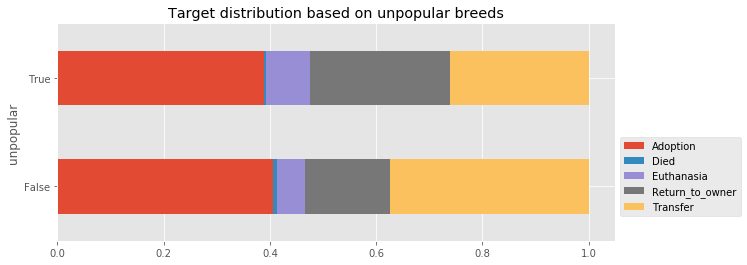

In [201]:
ax = data.groupby(by='unpopular')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on unpopular breeds',kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- Unpopular dogs have slightly larger percentage of euthanasia, albeit it is small.

#### Color

- Similar to breed, there are too many color types for us to visualize. What we can potentially look at is to see whether there is a difference between mix color versus pure color. 

In [202]:
len(data.Color.unique())

366

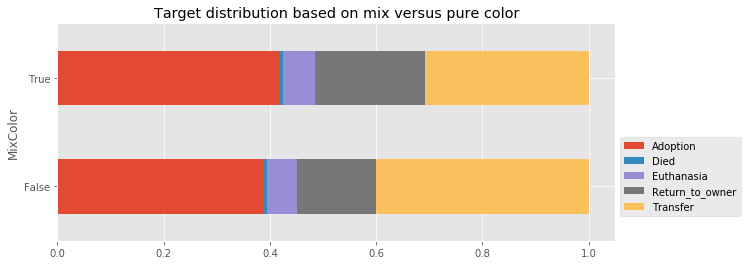

In [203]:
temp = ['/' in data.Color[x] for x in range(0, len(data.Color))]
data['MixColor'] = temp

ax = data.groupby(by='MixColor')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on mix versus pure color', kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

### Missing Values

Fortunately, most columns do not have missing values. The only two features that have missing values are 'Name' and 'Age'.

#### Name

We decided to use the missing value to create a new feature. The idea is that animals that do not have names may be less likely to be returned to owners.

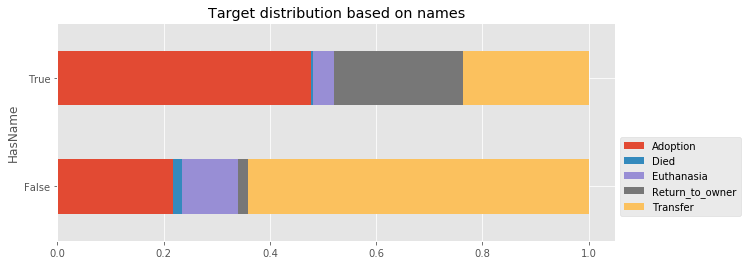

In [204]:
data['HasName'] = -data['Name'].isnull()

ax = data.groupby(by='HasName')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on names', kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

In line with our intutition, animals that have no names are much less likely to be returned to their owners. We also see lower adoption rate, and a higher euthanasia rate.

**Relationship Between Features**

In order to compare different features we convert categorical variables into integers

In [205]:
le = preprocessing.LabelEncoder()
data['AnimalType'] = le.fit_transform(data['AnimalType'])
data['SexuponOutcome'] = le.fit_transform(data['SexuponOutcome'])
data['AgeuponOutcome'] = le.fit_transform(data['AgeuponOutcome'])
data['OutcomeHour'] = le.fit_transform(data['OutcomeHour'])
# Calculate a correlation matrix of all features
data.loc[:,['AnimalType','SexuponOutcome','AgeuponOutcome','OutcomeHour','popular','unpopular','MixColor','HasName']].corr()

,AnimalType,SexuponOutcome,AgeuponOutcome,OutcomeHour,popular,unpopular,MixColor,HasName
AnimalType,1.000000,0.092029,0.058870,-0.081887,0.458788,0.403973,0.284541,0.304307
SexuponOutcome,0.092029,1.000000,0.077854,0.005000,0.067792,0.001807,0.037798,0.221411
AgeuponOutcome,0.058870,0.077854,1.000000,-0.001707,0.033074,0.004853,0.006424,0.087611
OutcomeHour,-0.081887,0.005000,-0.001707,1.000000,-0.035889,-0.042510,-0.007766,-0.093785
popular,0.458788,0.067792,0.033074,-0.035889,1.000000,-0.105533,0.074938,0.121434
unpopular,0.403973,0.001807,0.004853,-0.042510,-0.105533,1.000000,0.171163,0.133138
MixColor,0.284541,0.037798,0.006424,-0.007766,0.074938,0.171163,1.000000,0.113565
HasName,0.304307,0.221411,0.087611,-0.093785,0.121434,0.133138,0.113565,1.000000


It seems that our features are not strongly correlated with each other, which is very important when we apply prediction algorithm such as logistic regression.  

### Data Preparation
We have completed several modifications to the dataset in order to enrich the features and tested their improvements on predictive modeling.  Each step is completed on both the training and test sets.  All modifications are performed on the `raw_data` and `test_data` sets

#### AgeuponOutcome
We use the same data transformation as during EDA, this time keeping null values as zeroes

In [206]:
#Separate age into a number and a string
raw_data['Age_num'] = raw_data['AgeuponOutcome'].str[:2].str.strip().astype(int, raise_on_error=False)
raw_data['Age_str'] = raw_data['AgeuponOutcome'].str[2:].str.strip()

test_data['Age_num'] = test_data['AgeuponOutcome'].str[:2].str.strip().astype(int, raise_on_error=False)
test_data['Age_str'] = test_data['AgeuponOutcome'].str[2:].str.strip()

#Create an age factor column based on each possible unit of measure
factor = {'years':365, 'year':365, 'month':30, 'months':30, 'week': 7, 'weeks':7, 'day':1, 'days':1}
raw_data['Age_factor'] = raw_data['Age_str'].map(lambda x: factor[x] if x in factor.keys() else 0)
test_data['Age_factor'] = test_data['Age_str'].map(lambda x: factor[x] if x in factor.keys() else 0)

#Multiply the number in the age by the factor for comparable numerical column.  Drop and derivitive columns
raw_data['Age_num'] = raw_data['Age_num'].astype(float)
raw_data['Age_days'] = raw_data['Age_num'].mul(raw_data['Age_factor'], axis='index').fillna(0)
raw_data.drop(['AgeuponOutcome', 'Age_num', 'Age_str', 'Age_factor'], 1, inplace = True)

test_data['Age_num'] = test_data['Age_num'].astype(float)
test_data['Age_days'] = test_data['Age_num'].mul(test_data['Age_factor'], axis='index').fillna(0)
test_data.drop(['AgeuponOutcome', 'Age_num', 'Age_str', 'Age_factor'], 1, inplace = True)

#### Sex
Split out sex data into fixed/neutered and gender

In [207]:
split_raw_data = raw_data['SexuponOutcome'].str.split().apply(pd.Series)
split_raw_data.columns = ['fixed', 'gender']
raw_data['fixed'] = split_raw_data['fixed']
raw_data['gender'] = split_raw_data['gender']
raw_data.drop('SexuponOutcome', 1, inplace=True)

split_test_data = test_data['SexuponOutcome'].str.split().apply(pd.Series)
split_test_data.columns = ['fixed', 'gender']
test_data['fixed'] = split_test_data['fixed']
test_data['gender'] = split_test_data['gender']
test_data.drop('SexuponOutcome', 1, inplace=True)

#### DateTime
We turn a single timestamp feature into various components such as year, month, day, hour, minute, and whether or not it was a weekend.

In [208]:
#Build up date features
raw_data['DateTime'] = raw_data['DateTime'].astype(np.datetime64)
raw_data['Year'] = raw_data['DateTime'].map(lambda x: x.year)
raw_data['Month'] = raw_data['DateTime'].map(lambda x: x.month)
raw_data['Day'] = raw_data['DateTime'].map(lambda x: x.day)
raw_data['Hour'] = raw_data['DateTime'].map(lambda x: x.hour)
raw_data['Minute'] = raw_data['DateTime'].map(lambda x:x.minute)

test_data['DateTime'] = test_data['DateTime'].astype(np.datetime64)
test_data['Year'] = test_data['DateTime'].map(lambda x: x.year)
test_data['Month'] = test_data['DateTime'].map(lambda x: x.month)
test_data['Day'] = test_data['DateTime'].map(lambda x: x.day)
test_data['Hour'] = test_data['DateTime'].map(lambda x: x.hour)
test_data['Minute'] = test_data['DateTime'].map(lambda x:x.minute)

temp = pd.to_datetime(raw_data['DateTime']).dt.weekday
raw_data['weekend'] = temp.isin([5,6])
temp = pd.to_datetime(test_data['DateTime']).dt.weekday
test_data['weekend'] = temp.isin([5,6])


#### Breed
We split multiple breeds into a primary and secondary breed feature, as well as generating a `Mix` column for those that are identified as a mixed breed

In [209]:
#Does the breed contain a mix?
raw_data['Mix'] = raw_data['Breed'].map(lambda x: x.find('Mix') != -1)
test_data['Mix'] = test_data['Breed'].map(lambda x: x.find('Mix') != -1)
#Split breed into first and second
raw_data['First_Breed'] = raw_data['Breed'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
test_data['First_Breed'] = raw_data['Breed'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
raw_data['Second_Breed'] = raw_data['Breed'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)
test_data['Second_Breed'] = raw_data['Breed'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)
raw_data.drop('Breed', inplace=True, axis=1)
test_data.drop('Breed', inplace=True, axis=1)


#### Name
Name has far too many unique categories, we we instead reduced it into a binary variable of whether or not the animal had a name

In [210]:
#Does the animal have a name?
raw_data['has_name'] = raw_data['Name'].isnull()
test_data['has_name'] = test_data['Name'].isnull()
raw_data.drop('Name', inplace=True, axis=1)
test_data.drop('Name', inplace=True, axis=1)

#### Color
Similar to breed, there can be multiple colors listed as well as the string `mix`.  We split the colors into a first and second color, as well as a mixed color feature.

In [211]:
raw_data['First_Color'] = raw_data['Color'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
raw_data['Second_Color'] = raw_data['Color'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)


test_data['First_Color'] = test_data['Color'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
test_data['Second_Color'] = test_data['Color'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)


raw_data['Mix_Color'] = raw_data['Color'].map(lambda x: x.find('Mix') != -1)
test_data['Mix_Color'] = test_data['Color'].map(lambda x: x.find('Mix') != -1)

raw_data.drop('Color', axis=1, inplace=True)
test_data.drop('Color', axis=1, inplace=True)


#### Feature Hashing
Many of the features are categorical with potentially thousands of unique values.  In order to better model the data, we turn each possible category into its own feature.  After testing we found that removing some of the more rare categories, and simply lumping them into a `Rare_Breed` feature improved results.

In [214]:
raw_data.columns

Index([u'AnimalID', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'Age_days', u'fixed', u'gender', u'Year', u'Month',
       u'Day', u'Hour', u'Minute', u'weekend', u'Mix', u'First_Breed',
       u'Second_Breed', u'has_name', u'First_Color', u'Second_Color',
       u'Mix_Color'],
      dtype='object')

In [215]:
raw_data[['AnimalType','gender','First_Breed', 'Second_Breed','First_Color','Second_Color']]

,AnimalType,gender,First_Breed,Second_Breed,First_Color,Second_Color
0,Dog,Male,Shetland Sheepdog,NaN,Brown,White
1,Cat,Female,Domestic Shorthair,NaN,Cream Tabby,NaN
2,Dog,Male,Pit Bull,NaN,Blue,White
3,Cat,Male,Domestic Shorthair,NaN,Blue Cream,NaN
4,Dog,Male,Lhasa Apso,Miniature Poodle,Tan,NaN
5,Dog,Female,Cairn Terrier,Chihuahua Shorthair,Black,Tan
6,Cat,Male,Domestic Shorthair,NaN,Blue Tabby,NaN
7,Cat,NaN,Domestic Shorthair,NaN,Brown Tabby,NaN
8,Dog,Female,American Pit Bull Terrier,NaN,Red,White
9,Dog,Female,Cairn Terrier,NaN,White,NaN


In [216]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
hash_preds = ['AnimalType','gender','First_Breed', 'Second_Breed','First_Color','Second_Color']
non_hash_preds = ['OutcomeType', 'OutcomeSubtype', 'Age_days', 'Year', 'Month', 'Day', 'Hour', \
                  'Minute', 'weekend', 'Mix', 'has_name', 'Mix_Color']
hashed_train = pd.DataFrame(dv.fit_transform(raw_data[hash_preds].to_dict(orient='records')), 
                            columns=dv.get_feature_names()).fillna(0)
hashed_test = pd.DataFrame(dv.transform(test_data[hash_preds].to_dict(orient='records')), 
                           columns=dv.get_feature_names()).fillna(0)

In [219]:
raw_data

,AnimalID,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Age_days,fixed,gender,Year,Month,...,Hour,Minute,weekend,Mix,First_Breed,Second_Breed,has_name,First_Color,Second_Color,Mix_Color
0,A671945,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,365.0,Neutered,Male,2014,2,...,18,22,False,True,Shetland Sheepdog,NaN,False,Brown,White,False
1,A656520,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,365.0,Spayed,Female,2013,10,...,12,44,True,True,Domestic Shorthair,NaN,False,Cream Tabby,NaN,False
2,A686464,2015-01-31 12:28:00,Adoption,Foster,Dog,730.0,Neutered,Male,2015,1,...,12,28,True,True,Pit Bull,NaN,False,Blue,White,False
3,A683430,2014-07-11 19:09:00,Transfer,Partner,Cat,21.0,Intact,Male,2014,7,...,19,9,False,True,Domestic Shorthair,NaN,True,Blue Cream,NaN,False
4,A667013,2013-11-15 12:52:00,Transfer,Partner,Dog,730.0,Neutered,Male,2013,11,...,12,52,False,False,Lhasa Apso,Miniature Poodle,True,Tan,NaN,False
5,A677334,2014-04-25 13:04:00,Transfer,Partner,Dog,30.0,Intact,Female,2014,4,...,13,4,False,False,Cairn Terrier,Chihuahua Shorthair,False,Black,Tan,False
6,A699218,2015-03-28 13:11:00,Transfer,Partner,Cat,21.0,Intact,Male,2015,3,...,13,11,True,True,Domestic Shorthair,NaN,False,Blue Tabby,NaN,False
7,A701489,2015-04-30 17:02:00,Transfer,Partner,Cat,21.0,Unknown,NaN,2015,4,...,17,2,False,True,Domestic Shorthair,NaN,True,Brown Tabby,NaN,False
8,A671784,2014-02-04 17:17:00,Adoption,NaN,Dog,150.0,Spayed,Female,2014,2,...,17,17,False,True,American Pit Bull Terrier,NaN,False,Red,White,False
9,A677747,2014-05-03 07:48:00,Adoption,Offsite,Dog,365.0,Spayed,Female,2014,5,...,7,48,True,False,Cairn Terrier,NaN,True,White,NaN,False


In [218]:
hashed_train

,AnimalType=Cat,AnimalType=Dog,First_Breed=Abyssinian,First_Breed=Affenpinscher,First_Breed=Afghan Hound,First_Breed=Airedale Terrier,First_Breed=Akita,First_Breed=Alaskan Husky,First_Breed=Alaskan Malamute,First_Breed=American Bulldog,...,Second_Color=Silver Tabby,Second_Color=Tan,Second_Color=Tortie,Second_Color=Tricolor,Second_Color=White,Second_Color=Yellow,Second_Color=Yellow Brindle,gender,gender=Female,gender=Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [223]:
final_train_data = raw_data[non_hash_preds].merge(hashed_train, how='inner', left_index=True, right_index=True)
final_test_data = test_data[non_hash_preds[2:]].merge(hashed_test, how = 'inner', left_index=True, right_index=True)

In [226]:
final_train_data

,OutcomeType,OutcomeSubtype,Age_days,Year,Month,Day,Hour,Minute,weekend,Mix,...,Second_Color=Silver Tabby,Second_Color=Tan,Second_Color=Tortie,Second_Color=Tricolor,Second_Color=White,Second_Color=Yellow,Second_Color=Yellow Brindle,gender,gender=Female,gender=Male
0,Return_to_owner,NaN,365.0,2014,2,12,18,22,False,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,Euthanasia,Suffering,365.0,2013,10,13,12,44,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Adoption,Foster,730.0,2015,1,31,12,28,True,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Transfer,Partner,21.0,2014,7,11,19,9,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Transfer,Partner,730.0,2013,11,15,12,52,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,Transfer,Partner,30.0,2014,4,25,13,4,False,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Transfer,Partner,21.0,2015,3,28,13,11,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,Transfer,Partner,21.0,2015,4,30,17,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Adoption,NaN,150.0,2014,2,4,17,17,False,True,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,Adoption,Offsite,365.0,2014,5,3,7,48,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [225]:
final_train_data.to_csv('train_data_engineered.csv', index=False)
final_test_data.to_csv('test_data_engineered.csv', index=False)

## Modeling

### What model are we using?  Why?

### Assumptions?

### Regularization?

## Evaluation

### How well does the model perform?
- Accuracy
- ROC Curves
- Cross-validation
- other metrics?  performance?

#### AB test results (if any)

## Deployment

#### How is the model deployed?
- prediction service?
- serialized model?
- regression coefficients?

#### What support is provided after initial deployment?